# Redes Neuronales
## Fashion detector 

In [1]:
# dependencias necesarias
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import Image, display

# configuración para ocultar warnings
import warnings
warnings.filterwarnings('ignore')

# configuración para no expresar en notación científica
np.set_printoptions(suppress=True)

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

2022-05-30 08:52:42.239773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 08:52:42.239804: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# obtenemos las imágenes (x) y salidas/categorías (y) del dataset divididas en train y test
train, test = fashion_mnist.load_data()
(x_train, y_train) = train 
(x_test, y_test) = test

### 1) Análisis exploratorio sobre el conjunto de datos.  
Este es un dataset de 70000 imágenes en blanco y negro de 28x28 pixeles, de 10 categorías de prendas, divididas en un set de train con 60000 imágenes y otro de test de 10000. 

In [3]:
print('Cantidad y tamaño de imágenes de train:')
x_train.shape  

Cantidad y tamaño de imágenes de train:


(60000, 28, 28)

In [4]:
print('Cantidad y tamaño de imágenes de test:')
x_test.shape

Cantidad y tamaño de imágenes de test:


(10000, 28, 28)

In [3]:
# clases de prendas
CLASES = ["T-shirt/top", "Trouser", "Pullover", 
          "Dress", "Coat", "Sandal", "Shirt",
          "Sneaker", "Bag", "Ankle boot"]

Ejemplos de la imágenes sin modificaciones:

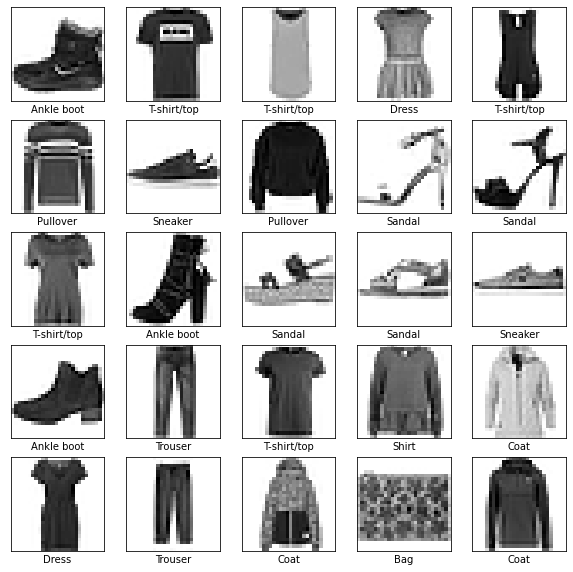

In [13]:
# función para mostrar imágenes
def mostrar_imagenes(entradas, salidas):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(entradas[i], cmap=plt.cm.binary)
        plt.xlabel(CLASES[salidas[i]])
    plt.show()

mostrar_imagenes(x_train, y_train)

Las categorías de prendas son las siguientes:

In [7]:
for clase in CLASES:
    print(clase)

T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot


A partir de los gráficos siguientes, podemos notar que el set de datos está completamente balanceado tanto en train como test. En el set de train, hay 6000 imágenes de cada tipo de prenda, mientras que en el set de test hay 1000 imágenes de cada uno.

In [8]:
# función para contar y graficar la cantidad de prendas por tipo
def distribucion(salidas, titulo=''):
    CANTIDADES = [0,0,0,0,0,0,0,0,0,0]
    for salida in salidas:
        CANTIDADES[salida] += 1
        
    display(titulo)
    plt.pie(CANTIDADES, labels=CLASES, autopct="%0.1f %%")

'Distribución de train'

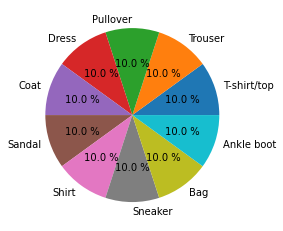

In [9]:
distribucion(y_train, 'Distribución de train')

'Distribución de test'

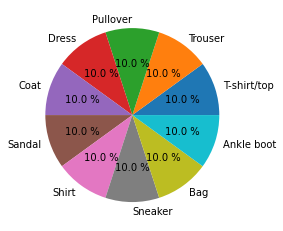

In [10]:
distribucion(y_test, 'Distribución de test')

### 2) Machine Learning.  
#### Modificación de las imágenes:  
##### - Modificar el tamaño 
En cuanto al tamaño de las imágenes, optamos por NO modificarlo, debido a que ya es lo suficientemente pequeño como para entrenar sin demorar demasiado.  
##### - Reescalar valores
Decidimos reescalar los valores de las imágenes entre 0 y 1, tanto en test como en train, ya que es necesario para que las redes funcionen correctamente. Esto se puede comprobar en los siguientes gráficos que muestran el rango de valores que posee una imagen del dataset antes y después de reescalar.

In [6]:
# reescalamos los valores de las imágenes
x_train_r = x_train / 255.0
x_test_r = x_test / 255.0

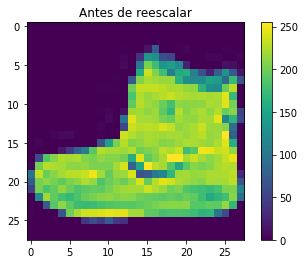

In [12]:
plt.figure()
plt.title('Antes de reescalar')
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

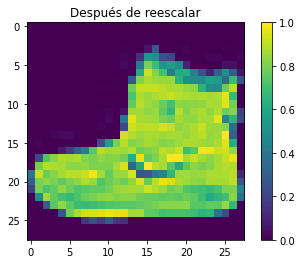

In [13]:
plt.figure()
plt.title('Después de reescalar')
plt.imshow(x_train_r[0])
plt.colorbar()
plt.grid(False)
plt.show()

*Algunas funciones para graficar:*

In [7]:
# función para graficar la curva de aprendizaje
def curva_aprendizaje(historial):
    plt.plot(historial.history['accuracy'], label='train')
    plt.plot(historial.history['val_accuracy'], label='test')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [8]:
# función para graficar la matriz de confusión
def matriz_confusion(modelo, dt_x, dt_y, title=''):
    predictions = modelo.predict(dt_x)
    pred_label = [np.argmax(i) for i in predictions]
    labels = dt_y
    
    conf_matrix = confusion_matrix(labels, pred_label)

    ax = sns.heatmap(conf_matrix, 
                cmap='Blues', 
                xticklabels=CLASES, 
                yticklabels=CLASES,
                annot=True,
                fmt='d')

    plt.xlabel('Predicted class') 
    plt.ylabel('True class') 
    
    print(title)
    plt.show()

#### ENTRENAMIENTO Y EVALUACIÓN DE MODELOS:  
Para este análisis decidimos definir y evaluar diversas redes neuronales.

En un principio definimos una red MLP con determinados parámetros, y en base a ella, probamos otras redes a las cuales les fuimos modificando diversas características como cantidad de capas y de neuronas, cantidad de épocas, tamaño del batch, tipo de función de activación, nivel de dropout, etc. 

Luego a la primer red MLP le agregamos una capa convolucional con ciertas características y así poder probar diversas redes de tipo convolucional, cambiando cantidad de filtros, tamañano del kernel, strides, cantidad de capas convolucionales, padding, entre otras cosas.

##### Redes Neuronales 1, 1-a y 1-b:
La red 1 obtuvo valores de accuracy por encima del 70%, tanto para train como para test, ya en la primera época. Este valor fue aumentando hasta alcanzar un accuracy superior al 90% para train y al 87% para test en la última época.  
Además, al observar la curva de aprendizaje, podemos corroborar que no hay sobreentrenamiento, ya que la diferencia del accuracy en train y test, es tan solo del 3% aproximadamente. Sin embargo, a medida que pasan las épocas, estas líneas parecen ir separándose, por lo cual entrenamos una red (1-a) con las mismas características, pero con 80 épocas. Tras analizar la curva de aprendizaje de esta última, comprobamos que el error creció y que la distancia entre las líneas de train y test continúa aumentando, lo cual, si bien sube más los valores del accuracy en test, podría llegar a generar algo de sobreentrenamiento si continuamos agregando épocas.  
También decidimos probar a entrenar la red con un batch más pequeño (1-b) y evaluar las medidas obtenidas, pero notamos que no hubo grandes modificaciones en el accuracy. En general, de los 3 casos, hasta ahora, el mejor es el primero, ya que se obtuvo un accuracy mayor en el set de test.  
Con respecto a las matrices de confusión, podemos ver que, son bastante similares en los 3 casos. En general, si bien hay muchos aciertos, también hay predicciones erróneas, pero en las clases de prendas que son similares (remera y camisa, botas y zapatillas, por ejemplo), lo cual tiene sentido.

##### - Red Neuronal 1
* Tipo: MLP.
* Capas: 3 densas, con 20, 20 y 10 neuronas en ese orden.
* Dropout: no aplica.
* Función de activación: 'tanh' en la primeras capas y 'softmax' en la de salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [16]:
model_mlp_1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


2022-05-30 06:38:21.229246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 06:38:21.229437: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 06:38:21.229531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (flor-VirtualBox): /proc/driver/nvidia/version does not exist
2022-05-30 06:38:21.231806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
history_mlp_1 = model_mlp_1.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25


2022-05-30 06:38:21.545842: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


240/240 [==============================] - 2s 8ms/step - loss: 0.8892 - accuracy: 0.7474 - val_loss: 0.5774 - val_accuracy: 0.8160
Epoch 2/25
240/240 [==============================] - 2s 9ms/step - loss: 0.4904 - accuracy: 0.8361 - val_loss: 0.4835 - val_accuracy: 0.8312
Epoch 3/25
240/240 [==============================] - 1s 5ms/step - loss: 0.4249 - accuracy: 0.8526 - val_loss: 0.4434 - val_accuracy: 0.8449
Epoch 4/25
240/240 [==============================] - 1s 5ms/step - loss: 0.3939 - accuracy: 0.8625 - val_loss: 0.4243 - val_accuracy: 0.8512
Epoch 5/25
240/240 [==============================] - 1s 5ms/step - loss: 0.3741 - accuracy: 0.8680 - val_loss: 0.4134 - val_accuracy: 0.8548
Epoch 6/25
240/240 [==============================] - 1s 4ms/step - loss: 0.3597 - accuracy: 0.8734 - val_loss: 0.4089 - val_accuracy: 0.8559
Epoch 7/25
240/240 [==============================] - 1s 4ms/step - loss: 0.3493 - accuracy: 0.8764 - val_loss: 0.4052 - val_accuracy: 0.8559
Epoch 8/25
240/24

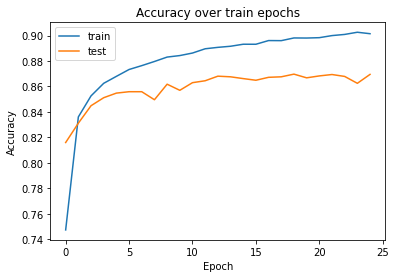

In [18]:
curva_aprendizaje(history_mlp_1)

2022-05-30 06:39:03.548819: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Matriz de confusión - Train


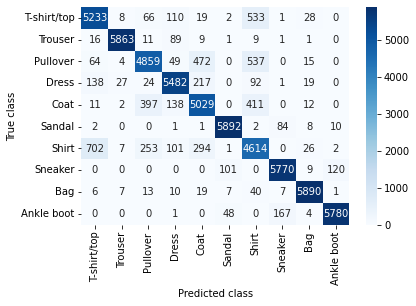

Matriz de confusión - Test


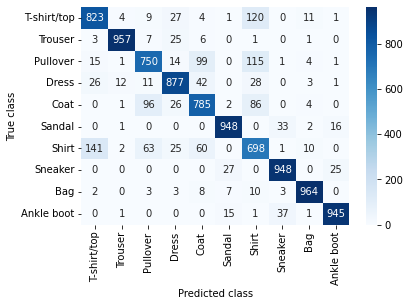

In [19]:
matriz_confusion(model_mlp_1, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_1, x_test_r, y_test, 'Matriz de confusión - Test')

##### - Red Neuronal 1-a
* Tipo: MLP.
* Capas: 2 densas, con 20, 20 y 10 neuronas en ese orden.
* Dropout: no aplica.
* Función de activación: 'tanh' en la primer capa y 'softmax' en la de salida.
* **Épocas: 80.**
* Tamaño del batch: 250.

In [20]:
model_mlp_1a = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_1a.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_1a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                15700     
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_mlp_1a = model_mlp_1a.fit(
    x_train_r,
    y_train,
    epochs=80,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/80


2022-05-30 06:39:07.484388: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


240/240 [==============================] - 3s 10ms/step - loss: 0.8949 - accuracy: 0.7271 - val_loss: 0.5785 - val_accuracy: 0.8110
Epoch 2/80
240/240 [==============================] - 1s 5ms/step - loss: 0.4942 - accuracy: 0.8335 - val_loss: 0.4847 - val_accuracy: 0.8287
Epoch 3/80
240/240 [==============================] - 1s 6ms/step - loss: 0.4294 - accuracy: 0.8509 - val_loss: 0.4527 - val_accuracy: 0.8407
Epoch 4/80
240/240 [==============================] - 2s 6ms/step - loss: 0.4000 - accuracy: 0.8609 - val_loss: 0.4252 - val_accuracy: 0.8497
Epoch 5/80
240/240 [==============================] - 1s 5ms/step - loss: 0.3799 - accuracy: 0.8666 - val_loss: 0.4209 - val_accuracy: 0.8506
Epoch 6/80
240/240 [==============================] - 2s 7ms/step - loss: 0.3646 - accuracy: 0.8702 - val_loss: 0.4028 - val_accuracy: 0.8563
Epoch 7/80
240/240 [==============================] - 2s 6ms/step - loss: 0.3529 - accuracy: 0.8744 - val_loss: 0.3989 - val_accuracy: 0.8591
Epoch 8/80
240/2

240/240 [==============================] - 1s 4ms/step - loss: 0.2283 - accuracy: 0.9169 - val_loss: 0.3945 - val_accuracy: 0.8665
Epoch 59/80
240/240 [==============================] - 1s 5ms/step - loss: 0.2266 - accuracy: 0.9183 - val_loss: 0.3902 - val_accuracy: 0.8658
Epoch 60/80
240/240 [==============================] - 1s 4ms/step - loss: 0.2264 - accuracy: 0.9179 - val_loss: 0.4026 - val_accuracy: 0.8642
Epoch 61/80
240/240 [==============================] - 1s 6ms/step - loss: 0.2264 - accuracy: 0.9187 - val_loss: 0.4106 - val_accuracy: 0.8617
Epoch 62/80
240/240 [==============================] - 1s 4ms/step - loss: 0.2247 - accuracy: 0.9188 - val_loss: 0.3976 - val_accuracy: 0.8670
Epoch 63/80
240/240 [==============================] - 1s 4ms/step - loss: 0.2233 - accuracy: 0.9199 - val_loss: 0.3931 - val_accuracy: 0.8683
Epoch 64/80
240/240 [==============================] - 1s 4ms/step - loss: 0.2217 - accuracy: 0.9198 - val_loss: 0.3918 - val_accuracy: 0.8692
Epoch 65/80

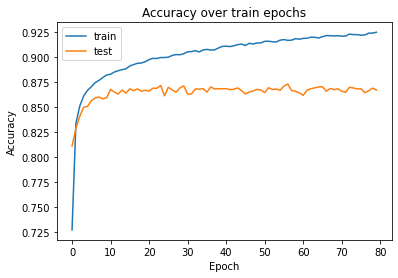

In [22]:
curva_aprendizaje(history_mlp_1a)

2022-05-30 06:41:31.165730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Matriz de confusión - Train


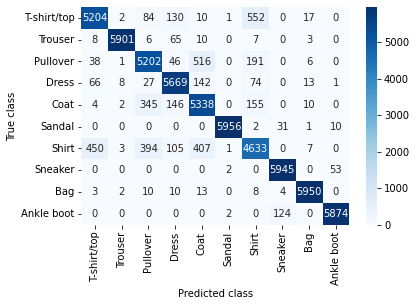

Matriz de confusión - Test


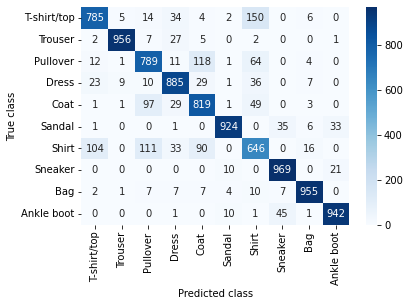

In [23]:
matriz_confusion(model_mlp_1a, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_1a, x_test_r, y_test, 'Matriz de confusión - Test')

##### - Red Neuronal 1-b
* Tipo: MLP.
* Capas: 2 densas, con 20, 20 y 10 neuronas en ese orden.
* Dropout: no aplica.
* Función de activación: 'tanh' en la primer capa y 'softmax' en la de salida.
* Épocas: 25.
* **Tamaño del batch: 125.**

In [24]:
model_mlp_1b = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_1b.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_1b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_mlp_1b = model_mlp_1b.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=125,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25


2022-05-30 06:41:34.164265: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


480/480 [==============================] - 2s 3ms/step - loss: 0.7447 - accuracy: 0.7756 - val_loss: 0.5229 - val_accuracy: 0.8166
Epoch 2/25
480/480 [==============================] - 1s 3ms/step - loss: 0.4472 - accuracy: 0.8443 - val_loss: 0.4474 - val_accuracy: 0.8402
Epoch 3/25
480/480 [==============================] - 1s 3ms/step - loss: 0.4007 - accuracy: 0.8574 - val_loss: 0.4247 - val_accuracy: 0.8491
Epoch 4/25
480/480 [==============================] - 1s 3ms/step - loss: 0.3763 - accuracy: 0.8649 - val_loss: 0.4103 - val_accuracy: 0.8521
Epoch 5/25
480/480 [==============================] - 1s 3ms/step - loss: 0.3597 - accuracy: 0.8707 - val_loss: 0.3986 - val_accuracy: 0.8554
Epoch 6/25
480/480 [==============================] - 1s 3ms/step - loss: 0.3461 - accuracy: 0.8754 - val_loss: 0.3871 - val_accuracy: 0.8602
Epoch 7/25
480/480 [==============================] - 1s 3ms/step - loss: 0.3360 - accuracy: 0.8782 - val_loss: 0.3781 - val_accuracy: 0.8610
Epoch 8/25
480/48

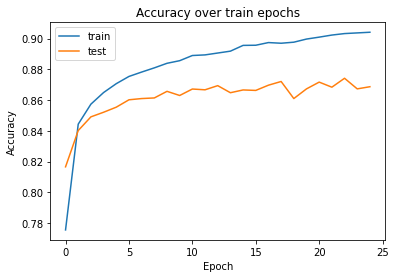

In [26]:
curva_aprendizaje(history_mlp_1b)

Matriz de confusión - Train


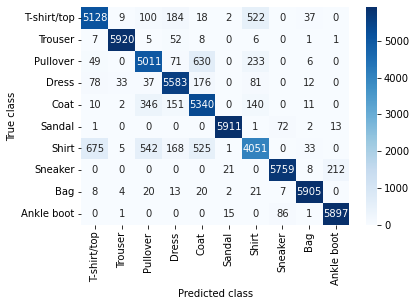

Matriz de confusión - Test


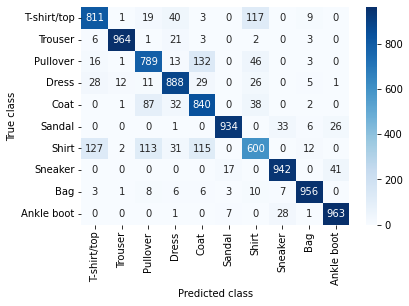

In [27]:
matriz_confusion(model_mlp_1b, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_1b, x_test_r, y_test, 'Matriz de confusión - Test')

##### Redes Neuronales 2, 2-a y 2-b:
Para la red 2, mantuvimos los valores de la red 1, a excepción del número de capas y neuronas, que decidimos aumentar. Tras el entrenamiento, esta obtuvo una diferencia mayor en el accuracy con respecto a la red 1 en ambos sets. Además, podemos ver que el error, para esta red con más parámetros, disminuyó.  
Tras modificar la cantidad de épocas en el entrenamiento (red 2-a), también pudimos comprobar que, si bien aumentaba la métrica en train, esta comenzaba a alejarse de los valores de test, confirmando nuevamente que si continuáramos agregando épocas, podría llegar a sobreentrenar.  
Por otra parte, decidimos probar una red con mucha más cantidad de capas y neuronas (2-b). Tras entrenarla, comprobamos que tan solo en 10 épocas el accuracy llegaba a valores del 10%, lo cual indica que tener una gran cantidad de parámetros no es bueno, tal y como vimos en la teoría. Esto también se puede comprobar en las matrices de confusión, ya que la red solo predice Shirt.

##### - Red Neuronal 2  
* Tipo: MLP.
* **Capas: 10 densas, con 60, 60, 60, 60, 40, 40, 40, 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la de salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [28]:
model_mlp_2 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),   
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 60)                47100     
                                                                 
 dense_10 (Dense)            (None, 60)                3660      
                                                                 
 dense_11 (Dense)            (None, 60)                3660      
                                                                 
 dense_12 (Dense)            (None, 60)                3660      
                                                                 
 dense_13 (Dense)            (None, 40)                2440      
                                                                 
 dense_14 (Dense)            (None, 40)               

In [29]:
history_mlp_2 = model_mlp_2.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 2s 6ms/step - loss: 0.7933 - accuracy: 0.7650 - val_loss: 0.5435 - val_accuracy: 0.8165
Epoch 2/25
240/240 [==============================] - 2s 6ms/step - loss: 0.4414 - accuracy: 0.8538 - val_loss: 0.4507 - val_accuracy: 0.8436
Epoch 3/25
240/240 [==============================] - 2s 6ms/step - loss: 0.3839 - accuracy: 0.8681 - val_loss: 0.4092 - val_accuracy: 0.8545
Epoch 4/25
240/240 [==============================] - 2s 8ms/step - loss: 0.3551 - accuracy: 0.8753 - val_loss: 0.4184 - val_accuracy: 0.8533
Epoch 5/25
240/240 [==============================] - 3s 11ms/step - loss: 0.3358 - accuracy: 0.8825 - val_loss: 0.3828 - val_accuracy: 0.8654
Epoch 6/25
240/240 [==============================] - 4s 15ms/step - loss: 0.3214 - accuracy: 0.8868 - val_loss: 0.3726 - val_accuracy: 0.8673
Epoch 7/25
240/240 [==============================] - 3s 13ms/step - loss: 0.3110 - accuracy: 0.8881 - val_loss: 0.3617 - val_accuracy: 0.8682
Epo

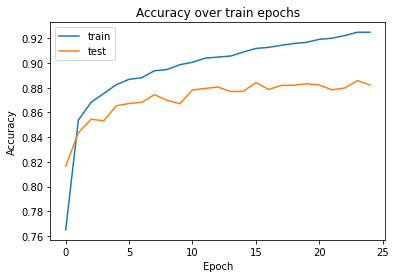

In [30]:
curva_aprendizaje(history_mlp_2)

Matriz de confusión - Train


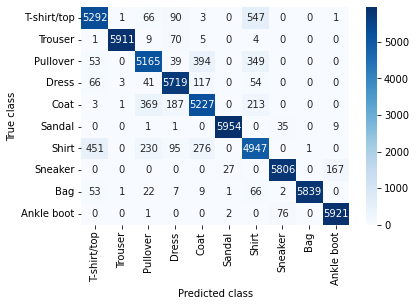

Matriz de confusión - Test


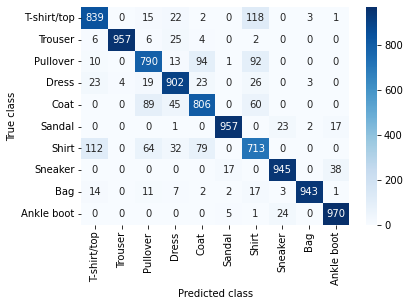

In [31]:
matriz_confusion(model_mlp_2, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_2, x_test_r, y_test, 'Matriz de confusión - Test')

##### - Red Neuronal 2-a  
* Tipo: MLP.
* **Capas: 10 densas, con 60, 60, 60, 60, 40, 40, 40, 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la de salida.
* **Épocas: 80.**
* Tamaño del batch: 250.

In [32]:
model_mlp_2a = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),   
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_2a.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_2a.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 60)                47100     
                                                                 
 dense_20 (Dense)            (None, 60)                3660      
                                                                 
 dense_21 (Dense)            (None, 60)                3660      
                                                                 
 dense_22 (Dense)            (None, 60)                3660      
                                                                 
 dense_23 (Dense)            (None, 40)                2440      
                                                                 
 dense_24 (Dense)            (None, 40)               

In [33]:
history_mlp_2a = model_mlp_2a.fit(
    x_train_r,
    y_train,
    epochs=80,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/80
240/240 [==============================] - 2s 8ms/step - loss: 0.7969 - accuracy: 0.7683 - val_loss: 0.5180 - val_accuracy: 0.8288
Epoch 2/80
240/240 [==============================] - 2s 7ms/step - loss: 0.4425 - accuracy: 0.8513 - val_loss: 0.4550 - val_accuracy: 0.8439
Epoch 3/80
240/240 [==============================] - 2s 7ms/step - loss: 0.3842 - accuracy: 0.8669 - val_loss: 0.4368 - val_accuracy: 0.8461
Epoch 4/80
240/240 [==============================] - 2s 7ms/step - loss: 0.3608 - accuracy: 0.8732 - val_loss: 0.4003 - val_accuracy: 0.8570
Epoch 5/80
240/240 [==============================] - 2s 7ms/step - loss: 0.3349 - accuracy: 0.8810 - val_loss: 0.3856 - val_accuracy: 0.8598
Epoch 6/80
240/240 [==============================] - 2s 7ms/step - loss: 0.3210 - accuracy: 0.8853 - val_loss: 0.3648 - val_accuracy: 0.8705
Epoch 7/80
240/240 [==============================] - 2s 8ms/step - loss: 0.3085 - accuracy: 0.8892 - val_loss: 0.3639 - val_accuracy: 0.8709
Epoch 

240/240 [==============================] - 3s 14ms/step - loss: 0.1267 - accuracy: 0.9528 - val_loss: 0.4259 - val_accuracy: 0.8830
Epoch 59/80
240/240 [==============================] - 3s 13ms/step - loss: 0.1257 - accuracy: 0.9528 - val_loss: 0.4298 - val_accuracy: 0.8845
Epoch 60/80
240/240 [==============================] - 2s 9ms/step - loss: 0.1260 - accuracy: 0.9530 - val_loss: 0.4343 - val_accuracy: 0.8793
Epoch 61/80
240/240 [==============================] - 3s 11ms/step - loss: 0.1182 - accuracy: 0.9553 - val_loss: 0.4335 - val_accuracy: 0.8838
Epoch 62/80
240/240 [==============================] - 3s 13ms/step - loss: 0.1195 - accuracy: 0.9556 - val_loss: 0.4417 - val_accuracy: 0.8840
Epoch 63/80
240/240 [==============================] - 3s 13ms/step - loss: 0.1138 - accuracy: 0.9584 - val_loss: 0.4588 - val_accuracy: 0.8812
Epoch 64/80
240/240 [==============================] - 3s 14ms/step - loss: 0.1200 - accuracy: 0.9562 - val_loss: 0.4499 - val_accuracy: 0.8859
Epoch

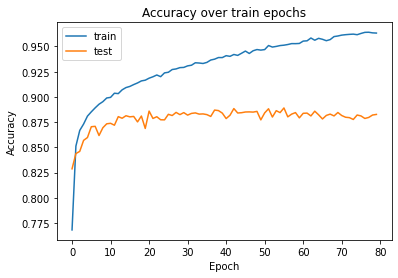

In [34]:
curva_aprendizaje(history_mlp_2a)

Matriz de confusión - Train


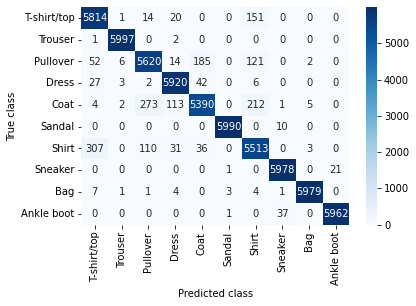

Matriz de confusión - Test


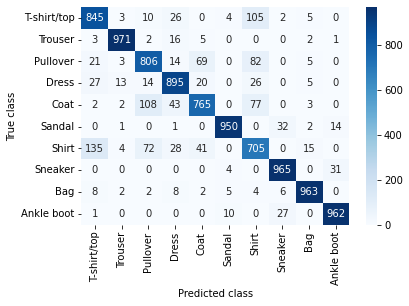

In [35]:
matriz_confusion(model_mlp_2a, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_2a, x_test_r, y_test, 'Matriz de confusión - Test')

##### - Red Neuronal 2-b  
* Tipo: MLP.
* **Capas: 31 densas, 3 de 200 neuronas, 7 de 120, 6 de 100, 5 de 80, 4 de 60, 3 de 40, 2 de 20 y la última de 10 neuronas, en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la de salida.
* **Épocas: 10.**
* Tamaño del batch: 250.

In [36]:
model_mlp_2b = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(200, activation='tanh'),
    Dense(200, activation='tanh'),
    Dense(200, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    Dense(80, activation='tanh'),
    Dense(80, activation='tanh'),
    Dense(80, activation='tanh'),
    Dense(80, activation='tanh'),
    Dense(80, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),
    Dense(60, activation='tanh'),   
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(40, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_2b.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_2b.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 200)               157000    
                                                                 
 dense_30 (Dense)            (None, 200)               40200     
                                                                 
 dense_31 (Dense)            (None, 200)               40200     
                                                                 
 dense_32 (Dense)            (None, 120)               24120     
                                                                 
 dense_33 (Dense)            (None, 120)               14520     
                                                                 
 dense_34 (Dense)            (None, 120)              

In [37]:
history_mlp_2b = model_mlp_2b.fit(
    x_train_r,
    y_train,
    epochs=10,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/10
240/240 [==============================] - 6s 20ms/step - loss: 0.9639 - accuracy: 0.6767 - val_loss: 0.7772 - val_accuracy: 0.7123
Epoch 2/10
240/240 [==============================] - 6s 24ms/step - loss: 0.7663 - accuracy: 0.7418 - val_loss: 0.8079 - val_accuracy: 0.7014
Epoch 3/10
240/240 [==============================] - 6s 24ms/step - loss: 0.9291 - accuracy: 0.6461 - val_loss: 1.2727 - val_accuracy: 0.4559
Epoch 4/10
240/240 [==============================] - 6s 23ms/step - loss: 2.3666 - accuracy: 0.1388 - val_loss: 2.3059 - val_accuracy: 0.1000
Epoch 5/10
240/240 [==============================] - 5s 22ms/step - loss: 2.3038 - accuracy: 0.0997 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 6/10
240/240 [==============================] - 6s 23ms/step - loss: 2.3039 - accuracy: 0.1007 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 7/10
240/240 [==============================] - 5s 21ms/step - loss: 2.3042 - accuracy: 0.0977 - val_loss: 2.3035 - val_accuracy: 0.1000

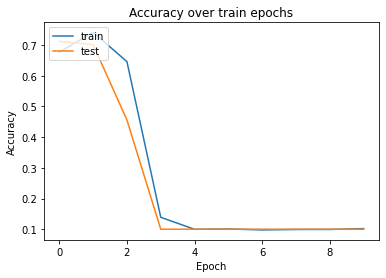

In [38]:
curva_aprendizaje(history_mlp_2b)

Matriz de confusión - Train


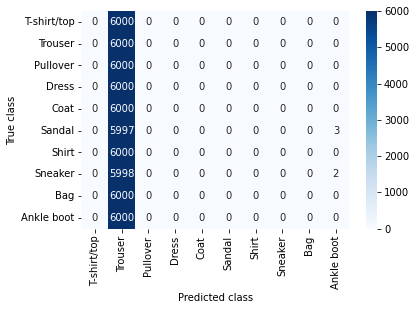

Matriz de confusión - Test


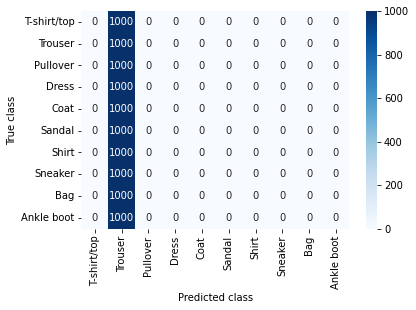

In [39]:
matriz_confusion(model_mlp_2b, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_2b, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 3:  
En esta red, con respecto a la primera, decidimos modificar la función de activación de las capas ocultas, reemplazando ‘tanh’ por ‘relu’, para evaluar si genera alguna diferencia. Tras el entrenamiento comprobamos que este cambio no generó mejores resultados, ya que el accuracy, tanto en train como en test, se redujo. También vimos que aumentó el error.    
* Tipo: MLP.
* Capas: 3 densas, con 20, 20 y 10 neuronas en ese orden.
* Dropout: no aplica.
* **Función de activación: 'relu' en la primeras capas y 'softmax' en la de salida.**
* Épocas: 25.
* Tamaño del batch: 250.

In [40]:
model_mlp_3 = Sequential([
    
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 20)                15700     
                                                                 
 dense_61 (Dense)            (None, 20)                420       
                                                                 
 dense_62 (Dense)            (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_mlp_3 = model_mlp_3.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 1s 4ms/step - loss: 0.9110 - accuracy: 0.6871 - val_loss: 0.5773 - val_accuracy: 0.7987
Epoch 2/25
240/240 [==============================] - 1s 4ms/step - loss: 0.5037 - accuracy: 0.8242 - val_loss: 0.4982 - val_accuracy: 0.8247
Epoch 3/25
240/240 [==============================] - 1s 3ms/step - loss: 0.4448 - accuracy: 0.8421 - val_loss: 0.4679 - val_accuracy: 0.8325
Epoch 4/25
240/240 [==============================] - 1s 6ms/step - loss: 0.4166 - accuracy: 0.8527 - val_loss: 0.4477 - val_accuracy: 0.8430
Epoch 5/25
240/240 [==============================] - 1s 4ms/step - loss: 0.3989 - accuracy: 0.8593 - val_loss: 0.4277 - val_accuracy: 0.8473
Epoch 6/25
240/240 [==============================] - 1s 5ms/step - loss: 0.3867 - accuracy: 0.8627 - val_loss: 0.4290 - val_accuracy: 0.8468
Epoch 7/25
240/240 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8650 - val_loss: 0.4125 - val_accuracy: 0.8514
Epoch 

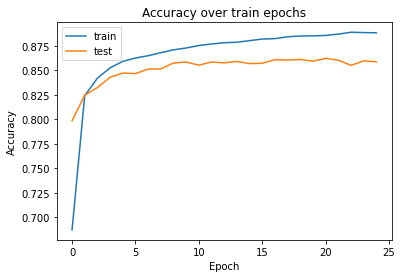

In [42]:
curva_aprendizaje(history_mlp_3)

Matriz de confusión - Train


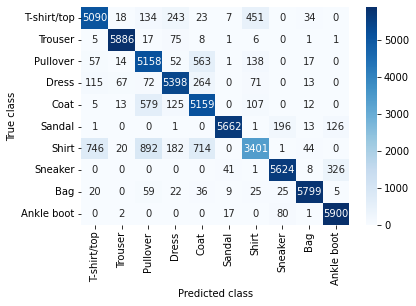

Matriz de confusión - Test


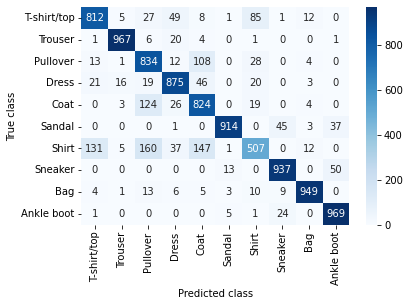

In [43]:
matriz_confusion(model_mlp_3, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_3, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 4:  
Para esta red, mantuvimos los valores de la red 1, a excepción del dropout, ya que decidimos aplicarle un 30% y analizar los resultados. Luego de entrenar, verificamos que esta modificación empeoró los valores del accuracy tanto para train, como para test. También vimos que aumentó el error.  
* Tipo: MLP.
* Capas: 3 densas, con 20, 20 y 10 neuronas en ese orden.
* **Dropout: 30% en capas ocultas.**
* Función de activación: 'tanh' en la primeras capas y 'softmax' en la de salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [44]:
model_mlp_4 = Sequential([
    
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 20)                15700     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_64 (Dense)            (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_65 (Dense)            (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trai

In [45]:
history_mlp_4 = model_mlp_4.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 1s 4ms/step - loss: 1.4465 - accuracy: 0.4636 - val_loss: 0.7753 - val_accuracy: 0.7328
Epoch 2/25
240/240 [==============================] - 1s 4ms/step - loss: 0.9769 - accuracy: 0.6268 - val_loss: 0.6466 - val_accuracy: 0.7637
Epoch 3/25
240/240 [==============================] - 1s 4ms/step - loss: 0.8590 - accuracy: 0.6712 - val_loss: 0.5915 - val_accuracy: 0.7897
Epoch 4/25
240/240 [==============================] - 1s 3ms/step - loss: 0.7962 - accuracy: 0.7003 - val_loss: 0.5489 - val_accuracy: 0.8112
Epoch 5/25
240/240 [==============================] - 1s 4ms/step - loss: 0.7624 - accuracy: 0.7161 - val_loss: 0.5413 - val_accuracy: 0.8231
Epoch 6/25
240/240 [==============================] - 1s 4ms/step - loss: 0.7404 - accuracy: 0.7253 - val_loss: 0.5205 - val_accuracy: 0.8204
Epoch 7/25
240/240 [==============================] - 1s 4ms/step - loss: 0.7228 - accuracy: 0.7318 - val_loss: 0.5095 - val_accuracy: 0.8270
Epoch 

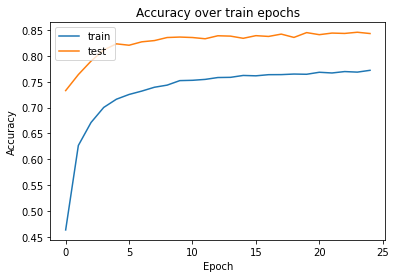

In [46]:
curva_aprendizaje(history_mlp_4)

Matriz de confusión - Train


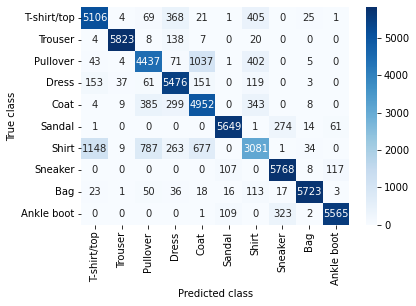

Matriz de confusión - Test


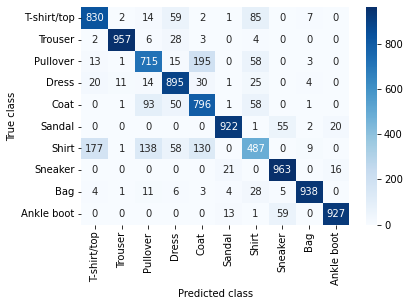

In [47]:
matriz_confusion(model_mlp_4, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_mlp_4, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 5:  
Esta red presenta las mismas características que la red 1, pero con la diferencia de que ahora incluye una capa convolucional de 4 filtros de 2x2 y stride 1. Esto hizo que el accuracy sea el mayor hasta ahora, con respecto a las demás redes analizadas, es decir que mejora el valor de la métrica. Además, también hizo que se redujera el error con respecto a dichas redes.  
* **Tipo: Convolucional.**
* **Capas: 1 convolucional con 4 filtros de 2x2 y stride 1, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [48]:
model_conv_1 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=4, kernel_size=(2, 2), strides=1, activation='tanh'), 
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 4)         20        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 flatten_8 (Flatten)         (None, 676)               0         
                                                                 
 dense_66 (Dense)            (None, 20)                13540     
                                                                 
 dense_67 (Dense)            (None, 20)                420       
                                                                 
 dense_68 (Dense)            (None, 10)                210       
                                                      

In [49]:
history_conv_1 = model_conv_1.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 10s 41ms/step - loss: 0.9112 - accuracy: 0.7365 - val_loss: 0.5865 - val_accuracy: 0.8035
Epoch 2/25
240/240 [==============================] - 9s 37ms/step - loss: 0.4945 - accuracy: 0.8303 - val_loss: 0.4776 - val_accuracy: 0.8325
Epoch 3/25
240/240 [==============================] - 9s 37ms/step - loss: 0.4215 - accuracy: 0.8511 - val_loss: 0.4263 - val_accuracy: 0.8498
Epoch 4/25
240/240 [==============================] - 9s 38ms/step - loss: 0.3862 - accuracy: 0.8628 - val_loss: 0.4009 - val_accuracy: 0.8594
Epoch 5/25
240/240 [==============================] - 9s 36ms/step - loss: 0.3658 - accuracy: 0.8690 - val_loss: 0.3870 - val_accuracy: 0.8629
Epoch 6/25
240/240 [==============================] - 8s 35ms/step - loss: 0.3484 - accuracy: 0.8750 - val_loss: 0.3794 - val_accuracy: 0.8651
Epoch 7/25
240/240 [==============================] - 8s 34ms/step - loss: 0.3344 - accuracy: 0.8796 - val_loss: 0.3603 - val_accuracy: 0.871

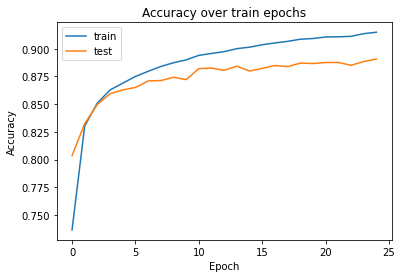

In [50]:
curva_aprendizaje(history_conv_1)

Matriz de confusión - Train


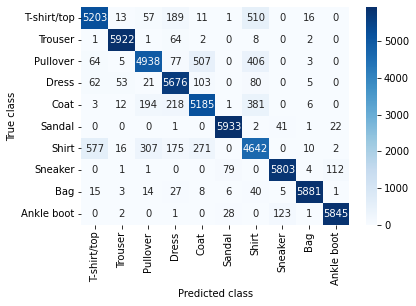

Matriz de confusión - Test


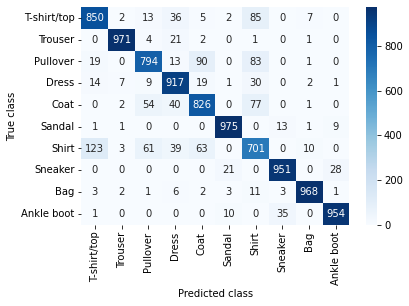

In [51]:
matriz_confusion(model_conv_1, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_1, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 6:    
Basándonos en la red 5, decidimos probar una red que modifique la cantidad de filtros de la capa de convolución, que ahora pasará de 4 a 8. Este cambió generó un aumento del accuracy con  respecto a la capa anterior, por lo cual consideramos que tener más filtros, en este caso, podría llegar a ser una mejor opción. Además, también hizo que se redujera considerablemente el error, inclusive más que la red anterior.  
* Tipo: Convolucional.
* **Capas: 1 convolucional con 8 filtros de 2x2 y stride 1, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [52]:
model_conv_2 = Sequential([    
    Convolution2D(input_shape=(28, 28, 1), filters=8, kernel_size=(2, 2), strides=1, activation='tanh'), 
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 27, 27, 8)         40        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 1352)              0         
                                                                 
 dense_69 (Dense)            (None, 20)                27060     
                                                                 
 dense_70 (Dense)            (None, 20)                420       
                                                                 
 dense_71 (Dense)            (None, 10)                210       
                                                      

In [53]:
history_conv_2 = model_conv_2.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 10s 42ms/step - loss: 0.8929 - accuracy: 0.7467 - val_loss: 0.5511 - val_accuracy: 0.8172
Epoch 2/25
240/240 [==============================] - 10s 42ms/step - loss: 0.4557 - accuracy: 0.8484 - val_loss: 0.4345 - val_accuracy: 0.8490
Epoch 3/25
240/240 [==============================] - 10s 42ms/step - loss: 0.3880 - accuracy: 0.8665 - val_loss: 0.3977 - val_accuracy: 0.8612
Epoch 4/25
240/240 [==============================] - 10s 40ms/step - loss: 0.3547 - accuracy: 0.8768 - val_loss: 0.3706 - val_accuracy: 0.8693
Epoch 5/25
240/240 [==============================] - 11s 45ms/step - loss: 0.3325 - accuracy: 0.8831 - val_loss: 0.3662 - val_accuracy: 0.8684
Epoch 6/25
240/240 [==============================] - 10s 40ms/step - loss: 0.3183 - accuracy: 0.8875 - val_loss: 0.3654 - val_accuracy: 0.8678
Epoch 7/25
240/240 [==============================] - 11s 44ms/step - loss: 0.3046 - accuracy: 0.8922 - val_loss: 0.3387 - val_accuracy:

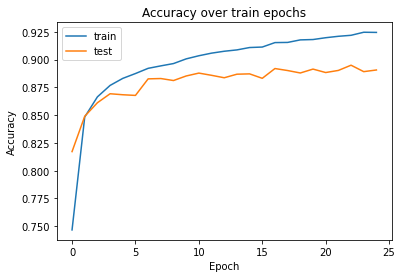

In [54]:
curva_aprendizaje(history_conv_2)

Matriz de confusión - Train


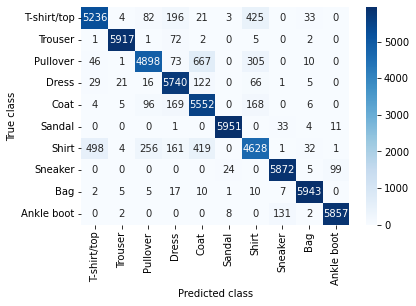

Matriz de confusión - Test


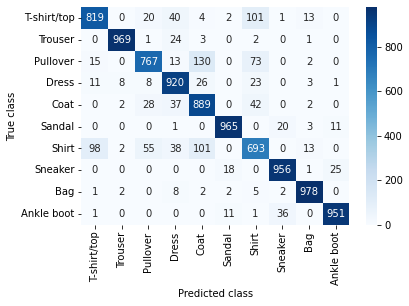

In [55]:
matriz_confusion(model_conv_2, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_2, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 7: 
Basándonos en la red 5, también decidimos probar una red que modifique el tamaño de los filtros de la capa de convolución, que ahora pasará de 4x4 a 8x8. Este cambió bajó, en muy pequeña medida, el valor del accuracy con respecto a las anteriores, por lo que podríamos decir que esta modificación, no aporta grandes mejoras. También podemos mencionar que, si bien, reduce un poco el error, este valor no es significativo respecto al error de las demás redes.  
* Tipo: Convolucional.
* **Capas: 1 convolucional con 4 filtros de 8x8 y stride 1, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [56]:
model_conv_3 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=4, kernel_size=(8, 8), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 21, 21, 4)         260       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 4)        0         
 2D)                                                             
                                                                 
 flatten_10 (Flatten)        (None, 400)               0         
                                                                 
 dense_72 (Dense)            (None, 20)                8020      
                                                                 
 dense_73 (Dense)            (None, 20)                420       
                                                                 
 dense_74 (Dense)            (None, 10)                210       
                                                     

In [57]:
history_conv_3 = model_conv_3.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 20s 81ms/step - loss: 1.0480 - accuracy: 0.6820 - val_loss: 0.6740 - val_accuracy: 0.7628
Epoch 2/25
240/240 [==============================] - 17s 69ms/step - loss: 0.5647 - accuracy: 0.8023 - val_loss: 0.5296 - val_accuracy: 0.8115
Epoch 3/25
240/240 [==============================] - 16s 65ms/step - loss: 0.4785 - accuracy: 0.8311 - val_loss: 0.4806 - val_accuracy: 0.8272
Epoch 4/25
240/240 [==============================] - 16s 66ms/step - loss: 0.4380 - accuracy: 0.8438 - val_loss: 0.4526 - val_accuracy: 0.8359
Epoch 5/25
240/240 [==============================] - 16s 66ms/step - loss: 0.4108 - accuracy: 0.8539 - val_loss: 0.4283 - val_accuracy: 0.8457
Epoch 6/25
240/240 [==============================] - 16s 65ms/step - loss: 0.3912 - accuracy: 0.8589 - val_loss: 0.4094 - val_accuracy: 0.8490
Epoch 7/25
240/240 [==============================] - 18s 75ms/step - loss: 0.3772 - accuracy: 0.8649 - val_loss: 0.4058 - val_accuracy:

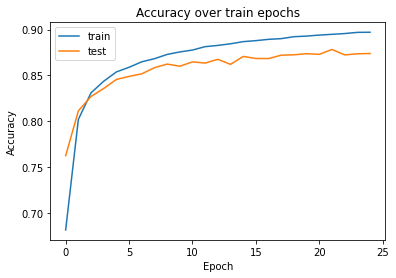

In [58]:
curva_aprendizaje(history_conv_3)

Matriz de confusión - Train


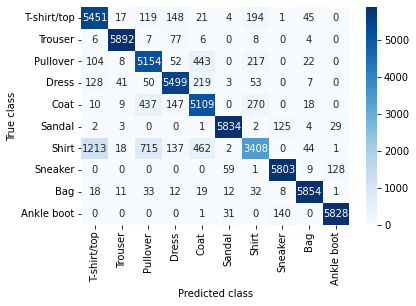

Matriz de confusión - Test


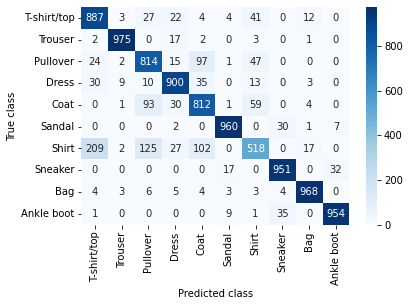

In [59]:
matriz_confusion(model_conv_3, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_3, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 8:  
A partir de la red 5, también decidimos probar una red que modifique el stride de la capa de convolución, que ahora pasará de 1 a 2. Este cambió no aportó una mejora significativa con respecto al accuracy de las redes anteriores, ya que puntualmente, presenta casi el mismo valor que la red 1. También podemos mencionar que, si bien, reduce un poco el error, este valor no es significativo respecto al error de las demás redes.  
* Tipo: Convolucional.
* **Capas: 1 convolucional con 4 filtros de 2x2 y stride 2, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [60]:
model_conv_4 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=4, kernel_size=(2, 2), strides=2, activation='tanh'), 
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 4)         20        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 4)          0         
 2D)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 196)               0         
                                                                 
 dense_75 (Dense)            (None, 20)                3940      
                                                                 
 dense_76 (Dense)            (None, 20)                420       
                                                                 
 dense_77 (Dense)            (None, 10)                210       
                                                     

In [61]:
history_conv_4 = model_conv_4.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 3s 11ms/step - loss: 1.1288 - accuracy: 0.6282 - val_loss: 0.6971 - val_accuracy: 0.7620
Epoch 2/25
240/240 [==============================] - 3s 11ms/step - loss: 0.5935 - accuracy: 0.7912 - val_loss: 0.5580 - val_accuracy: 0.7990
Epoch 3/25
240/240 [==============================] - 3s 11ms/step - loss: 0.5093 - accuracy: 0.8174 - val_loss: 0.5066 - val_accuracy: 0.8160
Epoch 4/25
240/240 [==============================] - 3s 10ms/step - loss: 0.4693 - accuracy: 0.8318 - val_loss: 0.4805 - val_accuracy: 0.8270
Epoch 5/25
240/240 [==============================] - 2s 10ms/step - loss: 0.4467 - accuracy: 0.8413 - val_loss: 0.4616 - val_accuracy: 0.8341
Epoch 6/25
240/240 [==============================] - 3s 11ms/step - loss: 0.4301 - accuracy: 0.8459 - val_loss: 0.4518 - val_accuracy: 0.8406
Epoch 7/25
240/240 [==============================] - 3s 11ms/step - loss: 0.4180 - accuracy: 0.8503 - val_loss: 0.4435 - val_accuracy: 0.8391

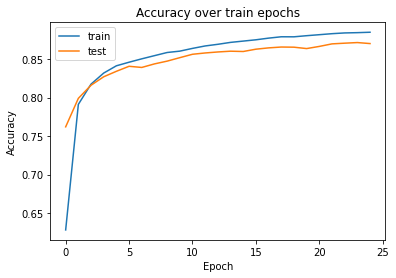

In [62]:
curva_aprendizaje(history_conv_4)

Matriz de confusión - Train


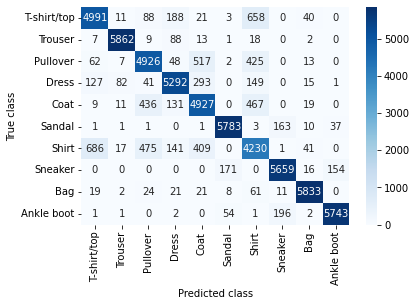

Matriz de confusión - Test


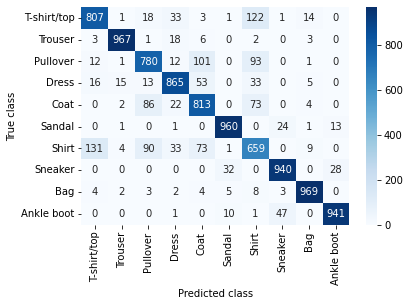

In [63]:
matriz_confusion(model_conv_4, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_4, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 9:  
Basándonos en la red 5, también decidimos probar una red que rellene la entrada con 0, es decir, utilizar padding. Este cambió mejoró, en muy pequeña medida, el valor del accuracy con respecto a la red 1 pero no con respecto a todas las anteriores, por lo que podríamos decir que esta modificación, no aporta grandes mejoras. También podemos mencionar que reduce considerablemente el error, con respecto al de las demás redes, pero no más que la red 6.  
* Tipo: Convolucional.
* **Capas: 1 convolucional con 4 filtros de 2x2, stride 1 y padding, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [64]:
model_conv_5 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=4, kernel_size=(2, 2), strides=1, padding='same', activation='tanh'), 
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_5.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 4)         20        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 4)        0         
 2D)                                                             
                                                                 
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_78 (Dense)            (None, 20)                15700     
                                                                 
 dense_79 (Dense)            (None, 20)                420       
                                                                 
 dense_80 (Dense)            (None, 10)                210       
                                                     

In [65]:
history_conv_5 = model_conv_5.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 8s 34ms/step - loss: 0.9548 - accuracy: 0.7265 - val_loss: 0.5846 - val_accuracy: 0.8016
Epoch 2/25
240/240 [==============================] - 9s 36ms/step - loss: 0.4954 - accuracy: 0.8343 - val_loss: 0.4753 - val_accuracy: 0.8350
Epoch 3/25
240/240 [==============================] - 8s 34ms/step - loss: 0.4249 - accuracy: 0.8519 - val_loss: 0.4303 - val_accuracy: 0.8479
Epoch 4/25
240/240 [==============================] - 11s 44ms/step - loss: 0.3862 - accuracy: 0.8641 - val_loss: 0.4041 - val_accuracy: 0.8559
Epoch 5/25
240/240 [==============================] - 13s 55ms/step - loss: 0.3611 - accuracy: 0.8711 - val_loss: 0.3870 - val_accuracy: 0.8626
Epoch 6/25
240/240 [==============================] - 12s 51ms/step - loss: 0.3437 - accuracy: 0.8775 - val_loss: 0.3678 - val_accuracy: 0.8670
Epoch 7/25
240/240 [==============================] - 10s 43ms/step - loss: 0.3271 - accuracy: 0.8826 - val_loss: 0.3558 - val_accuracy: 0.

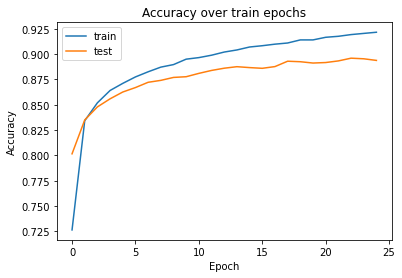

In [66]:
curva_aprendizaje(history_conv_5)

Matriz de confusión - Train


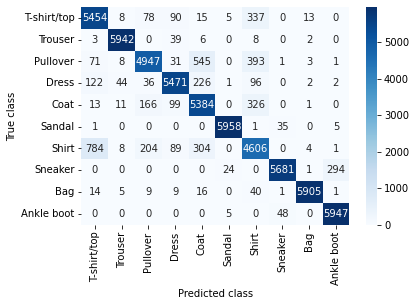

Matriz de confusión - Test


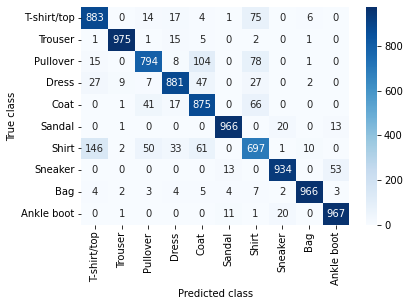

In [67]:
matriz_confusion(model_conv_5, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_5, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 10:  
Quizás trabajar con una sola capa convolucional es poco, así que decidimos probar una red que agregue más de una capa de convolución. Ahora trabajaremos con 3 capas en lugar de 1. Estas tendrán las mismas características que la red 5. Tras el entrenamiento podemos ver que este cambio aportó una suba en el valor de la métrica con respecto a dicha red 5, por lo cual es un factor a tener en cuenta a la hora de “mejorar” una red. Además, también hizo que se redujera considerablemente el error, casi al nivel de la red 6.  
* Tipo: Convolucional.
* **Capas: 3 convolucionales con 4 filtros de 2x2 y stride 1, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [68]:
model_conv_6 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=4, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=4, kernel_size=(2, 2), strides=1, activation='tanh'), 
    Convolution2D(filters=4, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_6.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 27, 27, 4)         20        
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 4)         68        
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 4)         68        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 4)        0         
 2D)                                                             
                                                                 
 flatten_13 (Flatten)        (None, 576)               0         
                                                                 
 dense_81 (Dense)            (None, 20)                11540     
                                                     

In [69]:
history_conv_6 = model_conv_6.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 18s 75ms/step - loss: 0.9326 - accuracy: 0.7347 - val_loss: 0.5758 - val_accuracy: 0.8033
Epoch 2/25
240/240 [==============================] - 19s 81ms/step - loss: 0.4921 - accuracy: 0.8310 - val_loss: 0.4712 - val_accuracy: 0.8323
Epoch 3/25
240/240 [==============================] - 20s 85ms/step - loss: 0.4243 - accuracy: 0.8505 - val_loss: 0.4351 - val_accuracy: 0.8442
Epoch 4/25
240/240 [==============================] - 20s 84ms/step - loss: 0.3886 - accuracy: 0.8611 - val_loss: 0.4058 - val_accuracy: 0.8544
Epoch 5/25
240/240 [==============================] - 24s 100ms/step - loss: 0.3640 - accuracy: 0.8694 - val_loss: 0.3894 - val_accuracy: 0.8613
Epoch 6/25
240/240 [==============================] - 20s 83ms/step - loss: 0.3466 - accuracy: 0.8751 - val_loss: 0.3766 - val_accuracy: 0.8652
Epoch 7/25
240/240 [==============================] - 20s 84ms/step - loss: 0.3330 - accuracy: 0.8801 - val_loss: 0.3655 - val_accuracy

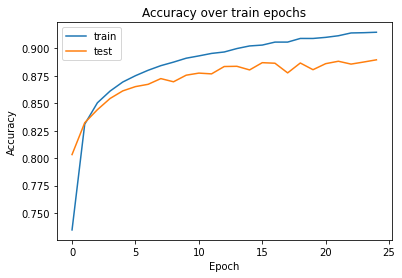

In [70]:
curva_aprendizaje(history_conv_6)

Matriz de confusión - Train


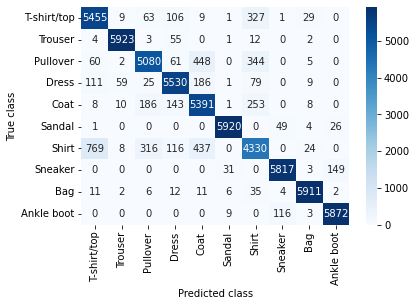

Matriz de confusión - Test


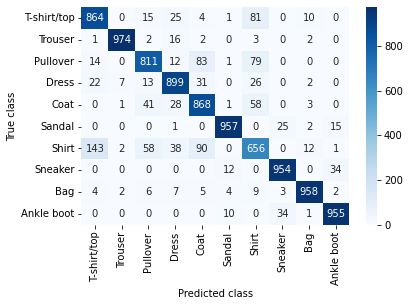

In [71]:
matriz_confusion(model_conv_6, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_6, x_test_r, y_test, 'Matriz de confusión - Test')

##### Red Neuronal 11:  
Para esta red, decidimos aplicar aquellos cambios que consideramos que, por los análisis anteriores, mejoraban en mayor medida, los valores del accuracy y del error, como por ejemplo, agregar más capas y aumentar la cantidad de filtros por capa. Estos cambios, confirmaron que aplicarlos, genera mejores resultados, ya que de todas las redes probadas, es la que mayor valor de accuracy obtuvo. Aunque cabe aclarar que no es una diferencia tan grande, sobre todo con respecto a la red 6. También podemos mencionar que redujo considerablemente el error, pero no más que dicha red 6. Podemos decir que con solo agregar más filtros podría ser suficiente para obtener buenos valores. Con respecto a la curva de aprendizaje, podemos ver que a medida que avanzan las épocas, las líneas de train y test se separan cada vez más, por lo cual si agregaríamos más épocas, el modelo podría llegar a sobreentrenar.  
* Tipo: Convolucional.
* **Capas: 4 convolucionales, 1 con 16 filtros y 3 con 8 filtros de 2x2 y stride 1, un max pooling de 2x2 y 3 densas, con 20, 20 y 10 neuronas en ese orden.**
* Dropout: no aplica.
* Función de activación: 'tanh' en cada capa y 'softmax' en la salida.
* Épocas: 25.
* Tamaño del batch: 250.

In [59]:
model_conv_7 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=16, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'), 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 16)        80        
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 8)         520       
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 8)         264       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 8)         264       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                      

In [60]:
history_conv_7 = model_conv_7.fit(
    x_train_r,
    y_train,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
240/240 [==============================] - 34s 142ms/step - loss: 0.8236 - accuracy: 0.7629 - val_loss: 0.5181 - val_accuracy: 0.8284
Epoch 2/25
240/240 [==============================] - 34s 142ms/step - loss: 0.4333 - accuracy: 0.8551 - val_loss: 0.4136 - val_accuracy: 0.8582
Epoch 3/25
240/240 [==============================] - 34s 140ms/step - loss: 0.3635 - accuracy: 0.8755 - val_loss: 0.3569 - val_accuracy: 0.8768
Epoch 4/25
240/240 [==============================] - 36s 148ms/step - loss: 0.3228 - accuracy: 0.8876 - val_loss: 0.3265 - val_accuracy: 0.8866
Epoch 5/25
240/240 [==============================] - 35s 144ms/step - loss: 0.2974 - accuracy: 0.8957 - val_loss: 0.3307 - val_accuracy: 0.8824
Epoch 6/25
240/240 [==============================] - 35s 145ms/step - loss: 0.2756 - accuracy: 0.9034 - val_loss: 0.3013 - val_accuracy: 0.8930
Epoch 7/25
240/240 [==============================] - 36s 148ms/step - loss: 0.2626 - accuracy: 0.9076 - val_loss: 0.2986 - val_ac

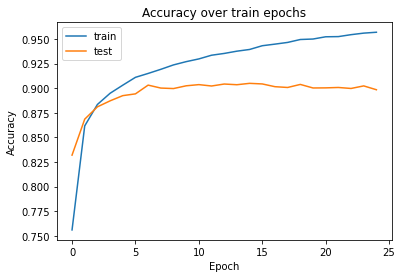

In [26]:
curva_aprendizaje(history_conv_7)

Matriz de confusión - Train


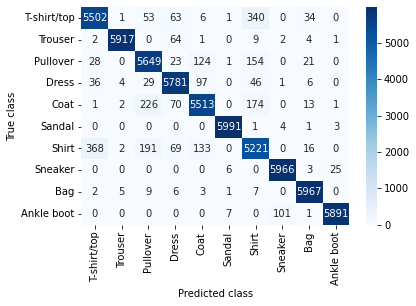

Matriz de confusión - Test


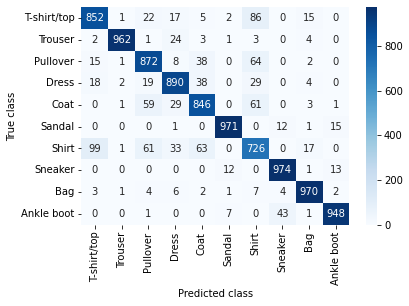

In [75]:
matriz_confusion(model_conv_7, x_train_r, y_train, 'Matriz de confusión - Train')
matriz_confusion(model_conv_7, x_test_r, y_test, 'Matriz de confusión - Test')

#### AUMENTACIÓN DE DATOS:
Para probar esta técnica elegimos el modelo que mayor valor de accuracy obtuvo en train, es decir, la red 11, que agregaba más capas convolucionales y más filtros. Por otra parte, también decidimos aplicarlo en la primer red creada, es decir la 1, para verificar si generaba mejoras.  
Para modificar las imágenes, alteramos parámetros como el ángulo de rotación, nivel de desplazamiento horizontal y vertical, brillo, espejar horizontalmente la imagen, y nivel de aumento.  
Una vez hecho esto, agregamos dichas imágenes al dataset original para generar el aumento de datos. Ahora pasaríamos de entrenar con 60000 imágenes a entrenar con 120000.

In [10]:
# generamos un dataset de train con imagénes alteradas; se obtiene en formato de tensor
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
)

train_alterado = data_generator.flow(
    x_train_r.reshape(60000,28,28,1),
    y_train,
    batch_size = 60000,
    shuffle=False)

In [11]:
# utilizamos el mismo generador (pero sin modificaciones) para obtener el dataset en formato de tensor
data_no_generator = ImageDataGenerator()

train_no_alterado = data_no_generator.flow(
    x_train_r.reshape(60000,28,28,1),
    y_train,
    batch_size = 60000,
    shuffle=False)

In [12]:
# separamos los tensores en imágenes y etiquetas
imagenes_a, etiquetas_a = train_alterado.next()
imagenes_n, etiquetas_n = train_no_alterado.next()

Podemos ver algunos ejemplos de las imágenes modificadas:

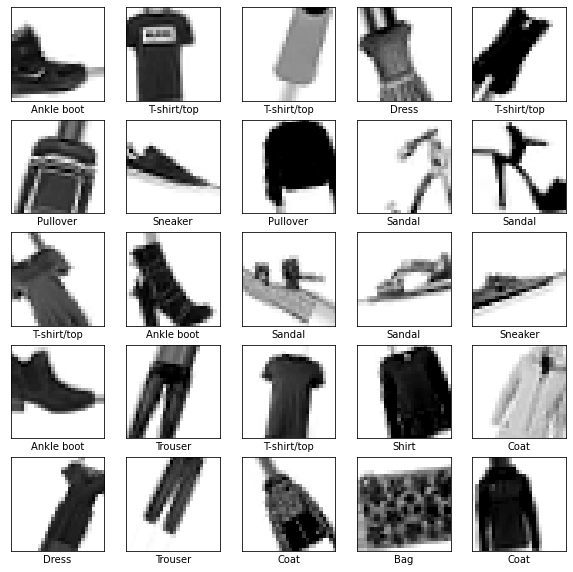

In [79]:
mostrar_imagenes(imagenes_a, etiquetas_a)

In [80]:
# concatenamos las imágenes originales con las modificadas
train_ampliado_imagenes = np.concatenate((
    imagenes_n,
    imagenes_a
))

In [81]:
# concatenamos los labels de las imágenes originales con los de las imágenes modificadas
train_ampliado_etiquetas = np.concatenate((
    etiquetas_n,
    etiquetas_a
))

In [82]:
# generamos una red con las mismas características que la nro. 11
model_conv_8 = Sequential([
    Convolution2D(input_shape=(28, 28, 1), filters=16, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'), 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_conv_8.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_8.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 16)        80        
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 8)         520       
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 8)         264       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 8)         264       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten_15 (Flatten)        (None, 1152)              0         
                                                     

In [83]:
history_conv_8 = model_conv_8.fit(
    train_ampliado_imagenes,
    train_ampliado_etiquetas,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
480/480 [==============================] - 77s 161ms/step - loss: 1.0181 - accuracy: 0.6514 - val_loss: 0.5337 - val_accuracy: 0.8123
Epoch 2/25
480/480 [==============================] - 68s 142ms/step - loss: 0.6886 - accuracy: 0.7477 - val_loss: 0.4488 - val_accuracy: 0.8437
Epoch 3/25
480/480 [==============================] - 70s 145ms/step - loss: 0.6232 - accuracy: 0.7685 - val_loss: 0.4094 - val_accuracy: 0.8525
Epoch 4/25
480/480 [==============================] - 70s 145ms/step - loss: 0.5795 - accuracy: 0.7850 - val_loss: 0.3883 - val_accuracy: 0.8599
Epoch 5/25
480/480 [==============================] - 76s 158ms/step - loss: 0.5585 - accuracy: 0.7923 - val_loss: 0.3841 - val_accuracy: 0.8624
Epoch 6/25
480/480 [==============================] - 71s 148ms/step - loss: 0.5356 - accuracy: 0.8011 - val_loss: 0.3728 - val_accuracy: 0.8652
Epoch 7/25
480/480 [==============================] - 70s 146ms/step - loss: 0.5220 - accuracy: 0.8061 - val_loss: 0.3534 - val_ac

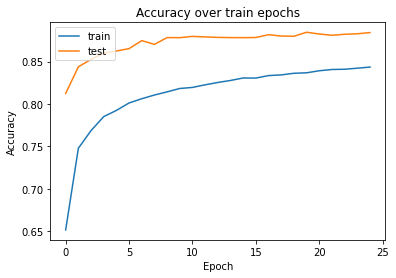

In [84]:
curva_aprendizaje(history_conv_8)

In [85]:
# generamos una red con las mismas características que la nro. 1
model_mlp_12 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax'),
])

model_mlp_12.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_12.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_90 (Dense)            (None, 20)                15700     
                                                                 
 dense_91 (Dense)            (None, 20)                420       
                                                                 
 dense_92 (Dense)            (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


In [86]:
history_mlp_12 = model_mlp_12.fit(
    train_ampliado_imagenes,
    train_ampliado_etiquetas,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_r, y_test)
)

Epoch 1/25
480/480 [==============================] - 1s 2ms/step - loss: 1.5827 - accuracy: 0.4303 - val_loss: 0.9980 - val_accuracy: 0.6594
Epoch 2/25
480/480 [==============================] - 1s 2ms/step - loss: 1.3133 - accuracy: 0.5179 - val_loss: 0.8324 - val_accuracy: 0.7053
Epoch 3/25
480/480 [==============================] - 1s 2ms/step - loss: 1.2209 - accuracy: 0.5499 - val_loss: 0.7473 - val_accuracy: 0.7307
Epoch 4/25
480/480 [==============================] - 1s 2ms/step - loss: 1.1642 - accuracy: 0.5679 - val_loss: 0.7419 - val_accuracy: 0.7394
Epoch 5/25
480/480 [==============================] - 1s 2ms/step - loss: 1.1206 - accuracy: 0.5842 - val_loss: 0.7467 - val_accuracy: 0.7231
Epoch 6/25
480/480 [==============================] - 1s 2ms/step - loss: 1.1372 - accuracy: 0.5712 - val_loss: 0.6837 - val_accuracy: 0.7534
Epoch 7/25
480/480 [==============================] - 1s 2ms/step - loss: 1.1261 - accuracy: 0.5800 - val_loss: 0.6768 - val_accuracy: 0.7639
Epoch 

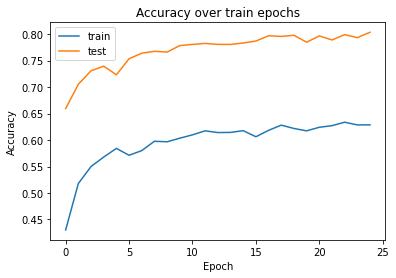

In [87]:
curva_aprendizaje(history_mlp_12)

Tras entrenar ambos modelos con el dataset aumentado, pudimos comprobar que, en este caso, la técnica no aportó mejoras, ya que el valor del accuracy obtenido en ambos modelos, fue mayor cuando se entrenó con el dataset original. Incluso el nivel de error se mantuvo más alto en los modelos con los dataset aumentados.    
Podemos suponer que esto se debe a que quizás las alteraciones sobre las imágenes fueron un tanto excesivas o no las adecuadas para estas imágenes.  

#### TRANFER LEARNING - VGG16:     
Uno de los modelos de alto rendimiento para el reconocimiento de imágenes que se pueden descargar y utilizar como base para el reconocimiento de imágenes es el VGG16. Este es el modelo que decidimos usar para aplicar la transferencia de aprendizaje.  
VGG16 contiene varios bloques de capas de convolución de filtros de 3x3 con stride de 1 y max pooling de 2x2 con stride 2. Al final, tiene 2 capas densas, seguidas de softmax para la salida. El 16 en VGG16 se refiere a que tiene 16 capas que tienen pesos.   
El modelo logra una precisión de prueba del 92,7% entre los 5 primeros datasets en ImageNet (conjuntos de datos de más de 14 millones de imágenes pertenecientes a 1000 clases).   
Para utilizar este modelo, reemplazamos las capas densas y de salida del mismo, por otras capas que nos servirán para predecir las imágenes de nuestro dataset. Manteniendo el peso de las capas convolucionales, entrenamos las capas agregadas con las imágenes de train, previamente alteradas para adaptarse a VGG.

In [14]:
# utilizamos el generador utilizado anteriormente (sin cambios) para obtener el dataset de test en formato de tensor
test_no_alterado = data_no_generator.flow(
    x_test_r.reshape(10000,28,28,1),
    y_test,
    batch_size = 10000,
    shuffle=False)

# separamos el tensor en imágenes y etiquetas
imagenes_n_t, etiquetas_n_t = test_no_alterado.next()

In [15]:
# modificamos las imágenes para que tengan 3 canales (rgb) de manera que sean toleradas por VGG16
x_train_color = tf.image.grayscale_to_rgb(tf.convert_to_tensor(imagenes_n))
x_test_color = tf.image.grayscale_to_rgb(tf.convert_to_tensor(imagenes_n_t))

# modificamos el tamaño de las imágenes al mínimo tolerado por VGG16
x_train_color = tf.image.resize(x_train_color, [32,32])
x_test_color = tf.image.resize(x_test_color, [32,32])

2022-05-30 08:55:05.787823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 08:55:05.787855: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 08:55:05.787872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (flor-VirtualBox): /proc/driver/nvidia/version does not exist
2022-05-30 08:55:05.790023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 08:55:05.792738: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 excee

In [16]:
print('Nuevo formato de las imágenes:')
x_train_color[0].shape

Nuevo formato de las imágenes:


TensorShape([32, 32, 3])

In [17]:
# descargamos VGG16 con sus pesos correspondientes descartando las capas densas
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))

# frizzamos las capas convolucionales para preservar los pesos durante el entrenamiento
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [18]:
# creamos un modelo que tome como base el VGG16 descargado adicionando nuevas capas densas
model_tl = Sequential([
    base_model,
    Flatten(),
    Dense(20, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(len(CLASES), activation='softmax')
])

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)
    
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                10260     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 14,725,578
Trainable params: 10,890
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
history_tl = model_tl.fit(
    x_train_color,
    etiquetas_n,
    epochs=25,
    batch_size=250,
    validation_data=(x_test_color, etiquetas_n_t)
)

Epoch 1/25
240/240 [==============================] - 745s 3s/step - loss: 1.0897 - accuracy: 0.6691 - val_loss: 0.6690 - val_accuracy: 0.7832
Epoch 2/25
240/240 [==============================] - 984s 4s/step - loss: 0.5661 - accuracy: 0.8088 - val_loss: 0.5174 - val_accuracy: 0.8204
Epoch 3/25
240/240 [==============================] - 939s 4s/step - loss: 0.4738 - accuracy: 0.8336 - val_loss: 0.4670 - val_accuracy: 0.8344
Epoch 4/25
240/240 [==============================] - 554s 2s/step - loss: 0.4343 - accuracy: 0.8448 - val_loss: 0.4419 - val_accuracy: 0.8414
Epoch 5/25
240/240 [==============================] - 656s 3s/step - loss: 0.4109 - accuracy: 0.8520 - val_loss: 0.4270 - val_accuracy: 0.8467
Epoch 6/25
240/240 [==============================] - 514s 2s/step - loss: 0.3956 - accuracy: 0.8569 - val_loss: 0.4278 - val_accuracy: 0.8448
Epoch 7/25
240/240 [==============================] - 545s 2s/step - loss: 0.3845 - accuracy: 0.8604 - val_loss: 0.4208 - val_accuracy: 0.8500

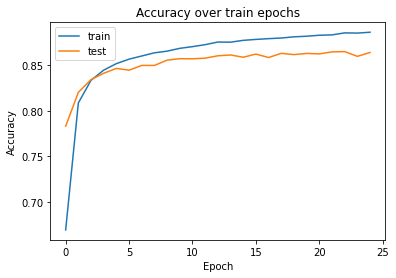

In [20]:
curva_aprendizaje(history_tl)

Matriz de confusión - Train


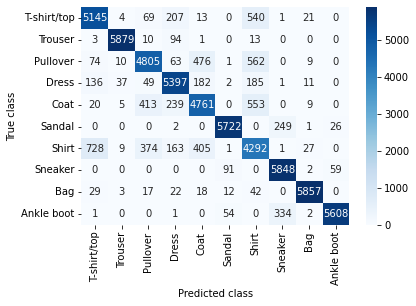

Matriz de confusión - Test


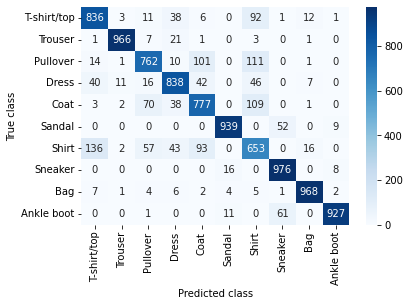

In [28]:
matriz_confusion(model_tl, x_train_color, etiquetas_n, 'Matriz de confusión - Train')
matriz_confusion(model_tl, x_test_color, etiquetas_n_t, 'Matriz de confusión - Test')

Tras el entrenamiento comprobamos que el modelo obtuvo un accuracy en el set de test bastante bueno, pero no superior a los modelos trabajados anteriormente. Creemos que un factor que podría influenciar su aprovechamiento es que VGG trabaja con imágenes a color, mientras que nuestro dataset está en escala de grises. Si bien hicimos las transformaciones necesarias para que respete este formato, algunos filtros que pudiesen haber sacado información relacionada a los colores podrían no estarse aprovechando.

### 3) Conclusiones.   
El análisis detallado de cada modelo se fue haciendo a medida que se probaban los mismos. Pero, en general, todos los modelos obtuvieron buenos valores de accuracy, ya que superaban en 80% en test en todos los casos, a excepción de la red 2b que contenía una gran cantidad de capas. Si bien el modelo que mayor valor de métrica obtuvo fue la red 11, la diferencia con respecto a los demás no fue mucha.  
Por otra parte, tras aplicar la técnica de aumentación de datos, los resultados obtenidos no fueron los esperados, ya que creímos que dicha técnica iba a generar mejores valores.  
Finalmente al probar la transferencia de aprendizaje, podemos decir que, si bien obtuvimos un buen resultado, quizás otros modelos pre entrenados hubieran sido más óptimos para nuestro dataset.

#### Desempeño del modelo por clase:  
Para evaluar el desempeño de un modelo por clase, elegimos la red 11, es decir, la misma que utilizamos para hacer aumentación de datos, ya que era la que mayor valor de accuracy obtenía.  
A partir de la matriz de confusión del modelo, podemos ver que este tiene un muy buen desempeño, mantiendo la mayoría de las predicciones en la categoría correcta, exceptuando casos en los que se confunde prendas que son bastante similares como: T-shirt/top y Shirt, Pullover y Coat, Coat y Shirt, entre otros.

Matriz de confusión - Test


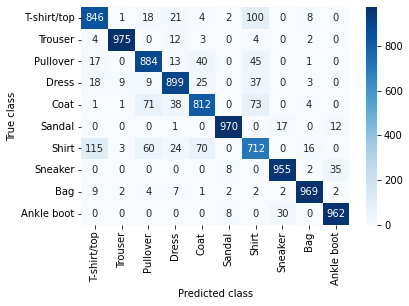

In [29]:
matriz_confusion(model_conv_7, x_test_r, y_test, 'Matriz de confusión - Test')

#### Aciertos y desaciertos:

In [30]:
# obtenemos las predicciones de test de la red 11 
predictions = model_conv_7.predict(x_test_r)

In [31]:
# funciones para graficar los ejemplos y mostrar los mayores % de confianza de las clases,
# diferenciando la clase acertada de las no acertadas
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CLASES[predicted_label],
                                100*np.max(predictions_array),
                                CLASES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [32]:
# función para mostrar casos de aciertos y desaciertos
def mostrar_aciertos_desaciertos(clase, acierto):
    count = 0
    for i, prediction in enumerate(predictions):
        if(acierto==1):
            if(CLASES[np.argmax(prediction)]==CLASES[y_test[i]]):
                if(clase==CLASES[np.argmax(prediction)]):
                    count+=1            
                    plt.figure(figsize=(4,2))
                    plt.subplot(1,2,1)
                    plot_image(i, prediction, y_test, x_test_r)
                    plt.subplot(1,2,2)
                    plot_value_array(i, prediction,  y_test)
                    plt.show()
        else:
            if(CLASES[np.argmax(prediction)]!=CLASES[y_test[i]]):
                if(clase==CLASES[y_test[i]]):
                    count+=1            
                    plt.figure(figsize=(4,2))
                    plt.subplot(1,2,1)
                    plot_image(i, prediction, y_test, x_test_r)
                    plt.subplot(1,2,2)
                    plot_value_array(i, prediction,  y_test)
                    plt.show()
        if(count==2):
            break           

###### T-shirt/top

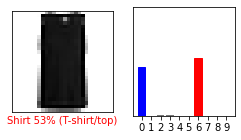

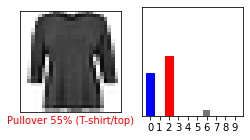

In [33]:
mostrar_aciertos_desaciertos('T-shirt/top', 0)

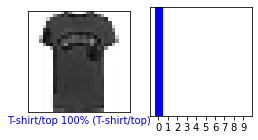

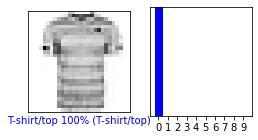

In [34]:
mostrar_aciertos_desaciertos('T-shirt/top', 1)

###### Trouser

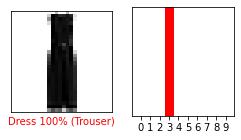

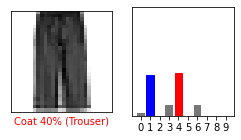

In [35]:
mostrar_aciertos_desaciertos('Trouser', 0)

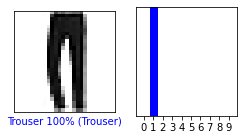

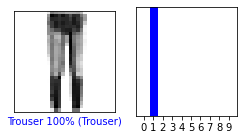

In [36]:
mostrar_aciertos_desaciertos('Trouser', 1)

###### Pullover

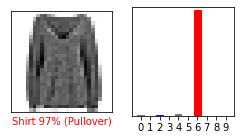

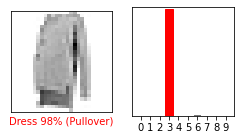

In [37]:
mostrar_aciertos_desaciertos('Pullover', 0)

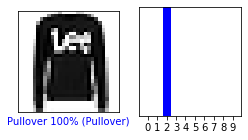

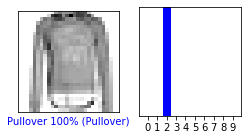

In [38]:
mostrar_aciertos_desaciertos('Pullover', 1)

###### Dress

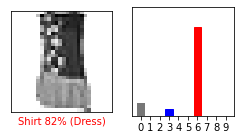

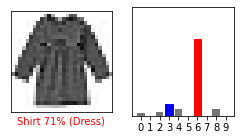

In [39]:
mostrar_aciertos_desaciertos('Dress', 0)

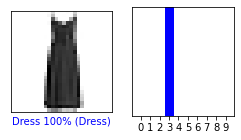

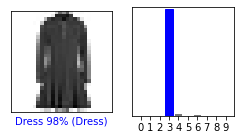

In [40]:
mostrar_aciertos_desaciertos('Dress', 1)

###### Coat

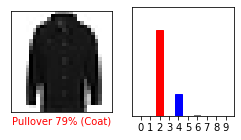

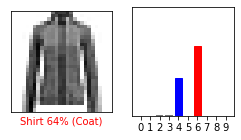

In [41]:
mostrar_aciertos_desaciertos('Coat', 0)

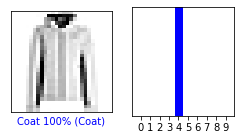

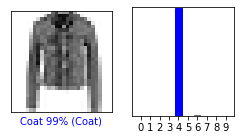

In [42]:
mostrar_aciertos_desaciertos('Coat', 1)

###### Sandal

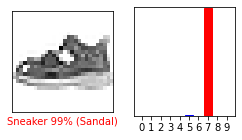

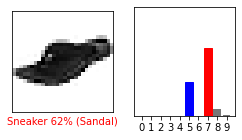

In [43]:
mostrar_aciertos_desaciertos('Sandal', 0)

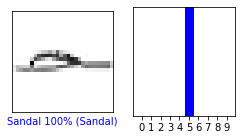

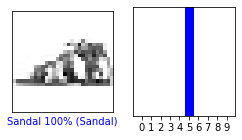

In [44]:
mostrar_aciertos_desaciertos('Sandal', 1)

###### Shirt

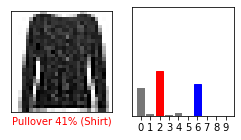

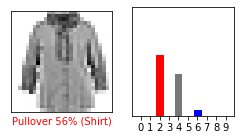

In [45]:
mostrar_aciertos_desaciertos('Shirt', 0)

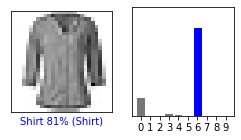

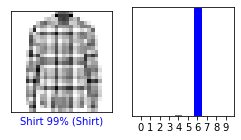

In [46]:
mostrar_aciertos_desaciertos('Shirt', 1)

###### Sneaker

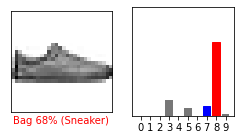

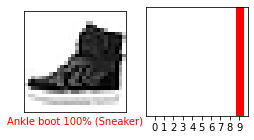

In [47]:
mostrar_aciertos_desaciertos('Sneaker', 0)

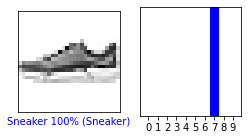

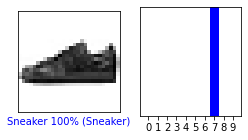

In [48]:
mostrar_aciertos_desaciertos('Sneaker', 1)

###### Bag

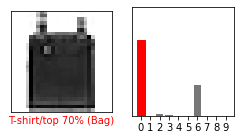

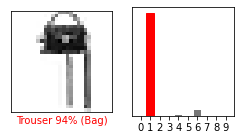

In [49]:
mostrar_aciertos_desaciertos('Bag', 0)

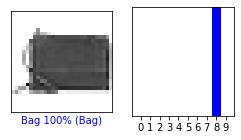

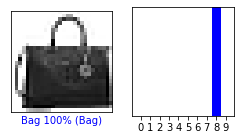

In [50]:
mostrar_aciertos_desaciertos('Bag', 1)

###### Ankle boot

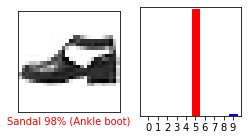

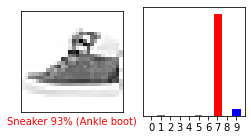

In [51]:
mostrar_aciertos_desaciertos('Ankle boot', 0)

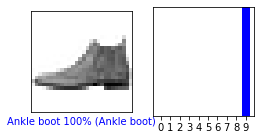

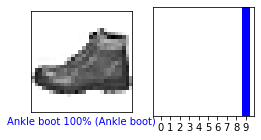

In [52]:
mostrar_aciertos_desaciertos('Ankle boot', 1)

#### Casos reales:

Decidimos probar dicha red 11 con otras imágenes de prendas, fuera del dataset. Como podemos ver las predicciones no fueron muy buenas, ya que de 4 casos, solo acertó un caso y con una probabilidad baja.  
Esto puede indicarnos que el modelo funciona bien solo con las imágenes del dataset, es decir que de alguna manera, está sobreentrenando.

In [61]:
# función para mostrar una imagen de ropa y predecir su tipo
def mostrar_predecir(image_path):
    image_array = img_to_array(load_img(image_path, grayscale=True, target_size=(28, 28)))
    inputs = np.array([image_array])
    predictions = model_conv_7.predict(inputs)
    display(Image(image_path, width=150))
    print("Prediction:", CLASES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

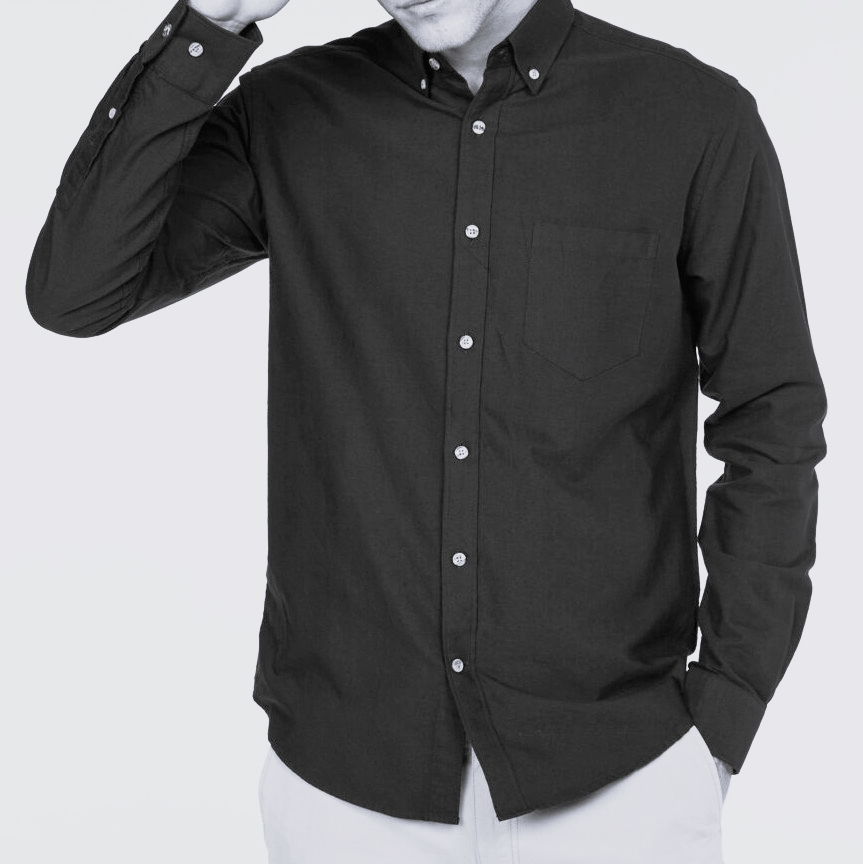

Prediction: Shirt
Prediction detail: [[0.24944392 0.00176221 0.00413266 0.00472607 0.02699059 0.00000024
  0.6564555  0.00126851 0.04051035 0.01470993]]


In [62]:
mostrar_predecir("./ropa/Shirt.jpg")

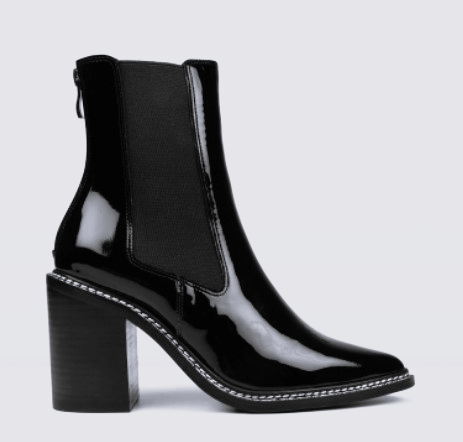

Prediction: Trouser
Prediction detail: [[0.00788565 0.97448516 0.00004509 0.00162712 0.000004   0.00038494
  0.00001126 0.00001099 0.01550363 0.00004214]]


In [64]:
mostrar_predecir("./ropa/Ankle_boot.jpg")

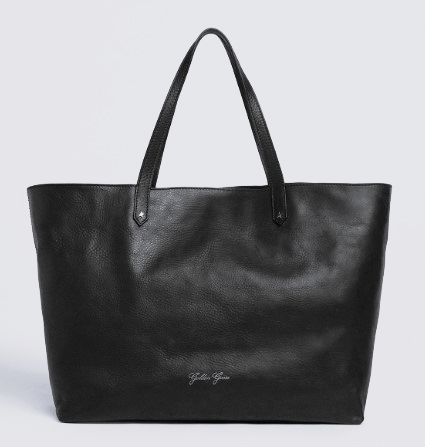

Prediction: Coat
Prediction detail: [[0.00486512 0.00013646 0.016123   0.0086742  0.5519034  0.0002763
  0.01133531 0.00002614 0.40661442 0.00004552]]


In [56]:
mostrar_predecir("./ropa/Bag.jpg")

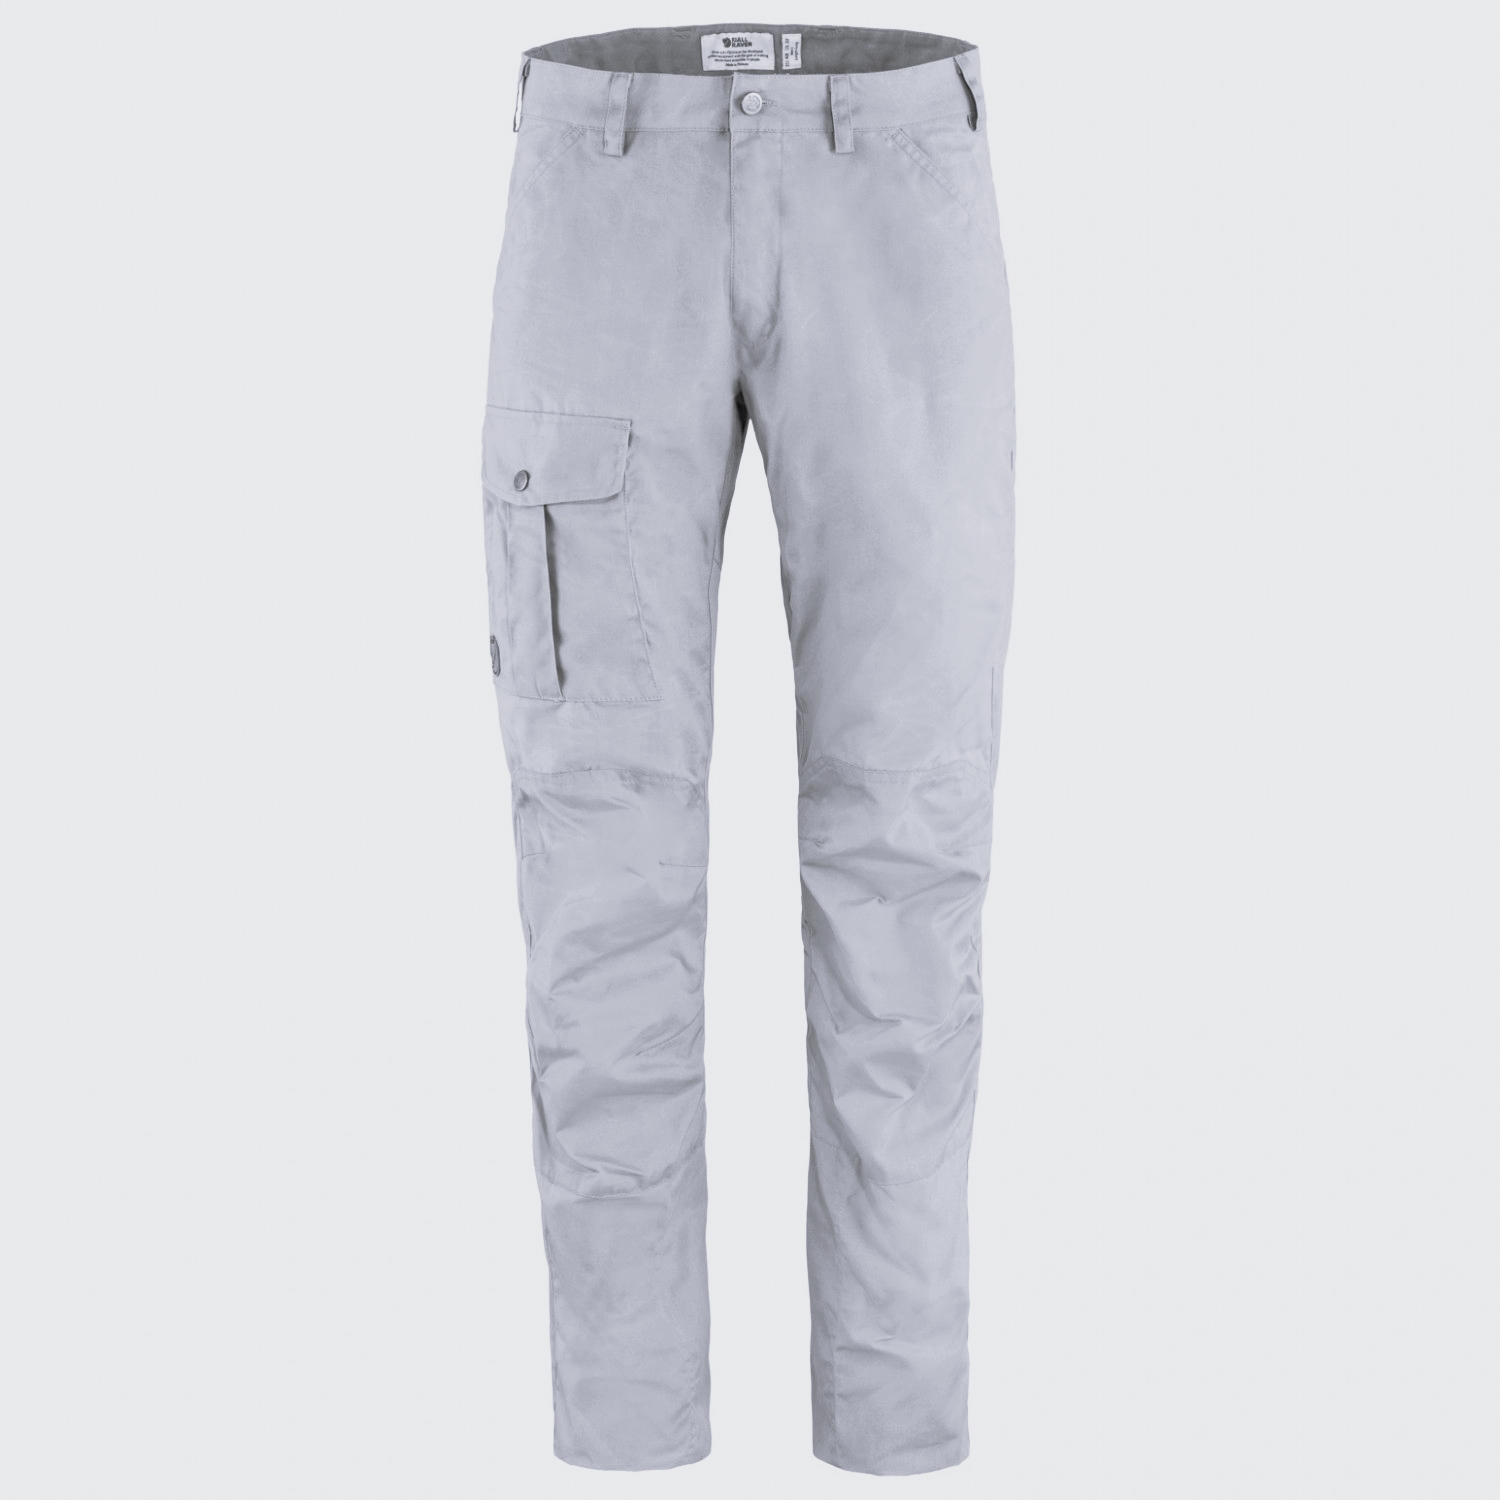

Prediction: Shirt
Prediction detail: [[0.06135163 0.04467131 0.00959444 0.00078252 0.026705   0.00011333
  0.8499893  0.00561955 0.00088971 0.00028316]]


In [65]:
mostrar_predecir("./ropa/Trouser.jpg")